In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('0017.hk')

[*********************100%***********************]  1 of 1 completed


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2010-03-25,51.959129,52.710182,51.344631,52.300514,29.860735,2536219.0,52.493969,52.328966,55.096356,-57.575865,-59.459566,-0.751053,-0.477943,52.058910,51.053067,1.005843,1.365551,6.821374,16.425878,53.392956
2010-03-26,52.095684,53.802620,52.027409,53.392956,30.484463,2510249.0,52.653283,52.425692,66.728957,-16.666641,-16.666641,0.955883,1.160717,52.264148,51.226392,1.037756,1.775211,35.279811,28.350674,53.666065
2010-03-29,53.461231,53.939175,53.461231,53.666065,30.640392,2631978.0,52.664662,52.590696,69.066249,-10.526300,-10.526300,0.068275,1.980045,52.479827,51.407108,1.072719,0.546219,40.712074,31.034403,53.188122
2010-03-30,53.256401,54.075729,52.915012,53.188122,30.367512,3142411.0,52.823976,52.698801,60.402809,-32.500024,-32.500024,0.955883,1.297268,52.588796,51.539035,1.049760,1.160717,19.626336,22.289705,51.890854
2010-03-31,52.641903,53.256401,51.686020,51.890854,29.626846,3351421.0,52.789838,52.693112,43.230895,-79.999888,-79.999888,-0.204830,-0.068275,52.481420,51.565096,0.916324,1.570381,-19.610331,2.111758,52.163963


In [5]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [6]:
X=sc.fit_transform(data.drop('Prediction',1))
Y = data["Prediction"].values.reshape(-1,1)
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1974, 1, 19) (1974, 1) (494, 1, 19) (494, 1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_81074/2608591593.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [7]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.01)
)

Metal device set to: Apple M1 Pro


2022-04-10 21:49:17.481307: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-10 21:49:17.481427: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=300,
    batch_size=10,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/300


2022-04-10 21:49:17.878569: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-10 21:49:19.054995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 21:49:19.249314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/178 [..............................] - ETA: 4:41 - loss: 1554.6549

2022-04-10 21:49:19.284289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 21:49:19.351002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 21:49:19.416967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


178/178 [==============================] - ETA: 0s - loss: 108.6977

2022-04-10 21:49:21.366583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 21:49:21.441768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 21:49:21.463854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


178/178 [==============================] - 4s 12ms/step - loss: 108.6977 - val_loss: 1746.1455
Epoch 2/300
178/178 [==============================] - 2s 10ms/step - loss: 42.3949 - val_loss: 1278.6764
Epoch 3/300
178/178 [==============================] - 2s 10ms/step - loss: 40.1961 - val_loss: 1062.3447
Epoch 4/300
178/178 [==============================] - 2s 10ms/step - loss: 37.1337 - val_loss: 1368.3151
Epoch 5/300
178/178 [==============================] - 2s 10ms/step - loss: 35.6719 - val_loss: 1179.2450
Epoch 6/300
178/178 [==============================] - 2s 11ms/step - loss: 31.5109 - val_loss: 1325.9532
Epoch 7/300
178/178 [==============================] - 2s 10ms/step - loss: 28.1223 - val_loss: 1313.8755
Epoch 8/300
178/178 [==============================] - 2s 10ms/step - loss: 24.5947 - val_loss: 1525.3918
Epoch 9/300
178/178 [==============================] - 2s 9ms/step - loss: 23.4198 - val_loss: 1781.0605
Epoch 10/300
178/178 [==============================] - 2s

178/178 [==============================] - 2s 9ms/step - loss: 3.4511 - val_loss: 171.0160
Epoch 80/300
178/178 [==============================] - 2s 9ms/step - loss: 3.3046 - val_loss: 180.5228
Epoch 81/300
178/178 [==============================] - 2s 10ms/step - loss: 5.7028 - val_loss: 147.3669
Epoch 82/300
178/178 [==============================] - 2s 9ms/step - loss: 4.4286 - val_loss: 167.5160
Epoch 83/300
178/178 [==============================] - 2s 9ms/step - loss: 4.0276 - val_loss: 194.6739
Epoch 84/300
178/178 [==============================] - 2s 9ms/step - loss: 3.5425 - val_loss: 181.0069
Epoch 85/300
178/178 [==============================] - 2s 10ms/step - loss: 4.9018 - val_loss: 167.8223
Epoch 86/300
178/178 [==============================] - 2s 10ms/step - loss: 3.9147 - val_loss: 171.7661
Epoch 87/300
178/178 [==============================] - 2s 10ms/step - loss: 3.5031 - val_loss: 179.0566
Epoch 88/300
178/178 [==============================] - 2s 10ms/step - lo

2022-04-10 21:52:07.047773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 21:52:07.124475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 21:52:07.180393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


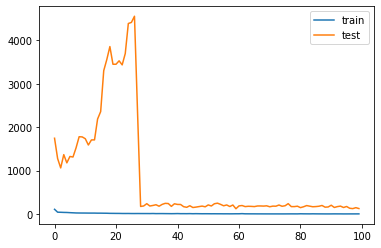

In [9]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

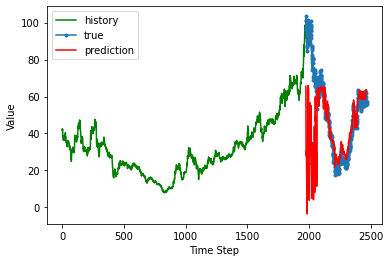

In [10]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

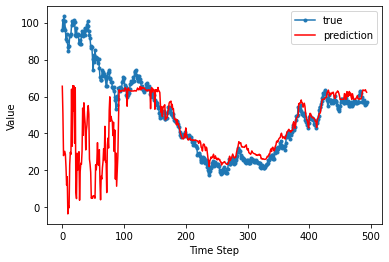

In [11]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [12]:
r2_score(y_test,y_pred)

-0.3142967099300982

In [13]:
mean_absolute_percentage_error(y_test,y_pred)

0.20327929486855378

In [14]:
mean_squared_error(y_test,y_pred,squared=False)

24.922358506519924

In [15]:
x_val=data_val.drop('Prediction',1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_81074/2328949661.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1)


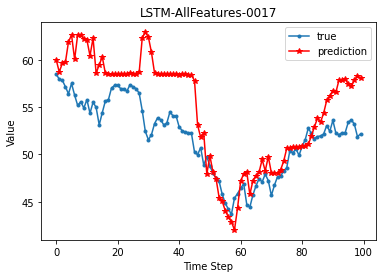

In [16]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('LSTM-AllFeatures-0017')
plt.legend()
plt.show()

In [17]:
r2_score(y_val,y_val_pred)

-0.12611842557074504

In [18]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.06099792454723569

In [19]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

4.0560882359600265